In [155]:
import requests
import datetime
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.pylab import rcParams
from scipy.optimize import leastsq
from statsmodels.tsa.stattools import adfuller
import pylab as pl
import math
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

In [70]:
def get_vip_list(s):
    data={}
    data['vip_list'] = s['id'].tolist()
    return pd.Series(data)
def to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d")

def func(x,p):#函数
    A,B=p
    return A*np.log(x)+B

def residuals(p,y,x):#残差
    ret =y-func(x,p)
    return ret

In [71]:
dsl = {'aggs': {'my_buckets': {'composite': {'size': 9999999,
                                       'sources': [{'日期': {'date_histogram': {'field': 'first_vip_created',
                                                                              'interval': '1d',
                                                                              'time_zone': '+00:00'}}},
                                                   {'id': {'terms': {'field': 'id'}}},

                                                  ]}}},
                 'query': {'bool': {'must': [{'range': {'first_vip_created': {'format': 'yyyy-MM-dd',
                                                              'gte': '2019-03-01',
                                                              'lte': '2019-05-28',
                                                              'time_zone': '+00:00'}}}]}}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_user_table', doc_type='user', body=dsl,
                        _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                        search_type='query_then_fetch')
df1 = json_normalize(res['aggregations']['my_buckets']['buckets'])
df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
df1['日期']= df1['日期'].apply(to_date)

In [72]:
dts=df1.groupby('日期').apply(get_vip_list).reset_index()

In [73]:
len(dts)

89

In [74]:
bar = progressbar
GMV_all=[]
for i in bar.progressbar(range(len(dts))):
    date=dts.iloc[i]['日期']
    dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}},
                                                       ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=1))[:10],
                                                        'lte': str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=21))[:10], 
                                                         'format': 'yyyy-MM-dd', 'time_zone': '+00:00'}}}, 
                                 {'terms':{'user_id': dts.iloc[i]['vip_list']}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
    es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
    res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                    search_type='query_then_fetch')
    df = json_normalize(res['aggregations']['my_buckets']['buckets'])
    df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df.columns))
    GMV=[]
    for j in range(len(df)):
        GMV.append(df.iloc[j]['折前GMV.value'])
    GMV_all.append(GMV)        

100% (89 of 89) |########################| Elapsed Time: 0:00:13 Time:  0:00:13


In [75]:
dts['GMV列表'] = GMV_all

In [76]:
dts.head()

,日期,vip_list,GMV列表
0,2019-03-01,"[190322, 193476, 265523, 266797, 300865, 30655...","[512.1999988555908, 488.09999799728394, 574.19..."
1,2019-03-02,"[176327, 185873, 194081, 200218, 227939, 25068...","[1519.210000762716, 580.6999998092651, 197.199..."
2,2019-03-03,"[180995, 205742, 391159, 393429, 406185, 40666...","[247.30000019073486, 186.5, 342.4000005722046,..."
3,2019-03-04,"[389155, 391613, 395736, 406388, 407504, 40825...","[231.22000028565526, 316.0099999997765, 542.70..."
4,2019-03-05,"[326113, 334963, 390749, 393925, 406360, 40859...","[597.4000000953674, 434.400000192225, 632.4999..."


In [258]:
dts.to_csv('总数据.csv')

In [101]:
GMV_list_all=[0]*21
for i in range(len(GMV_list_all)):
    for j in range(len(dts)):
        GMV_list_all[i]+=dts.iloc[j]['GMV列表'][i]
GMV_list_ave=[0]*21
for i in range(len(GMV_list_all)):
    GMV_list_ave[i]=GMV_list_all[i]/len(dts)
    

In [102]:
x3=np.linspace(1,22,1000) #用于画图精度的调节

x0 = []
for i in range(21):
    x0.append(i+1)

([<matplotlib.lines.Line2D at 0x7f881ff78198>],
 [<matplotlib.lines.Line2D at 0x7f881ff78320>])

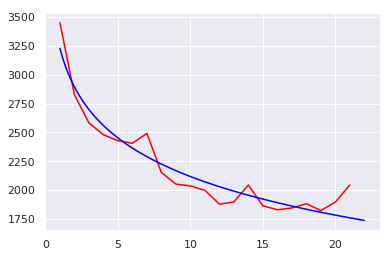

In [108]:
#x0=[range(21)] #x变量, 
x2=np.array(x0) #向量化x变量
y0=GMV_list_ave #y
y2=np.array(y0)#向量化
p0=[1,3400]#取值起始点
    
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法

pl.plot(x0,y0,label='Real',color='red'),pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [109]:
qs

(array([-482.92051693, 3228.89425221]), 1)

([<matplotlib.lines.Line2D at 0x7f881ffbc9b0>],
 [<matplotlib.lines.Line2D at 0x7f881ffcda58>])

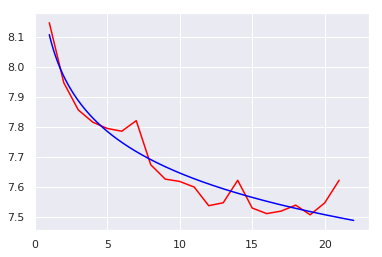

In [110]:
x3=np.linspace(1,22,1000) #用于画图精度的调节

x0 = []
for i in range(21):
    x0.append(i+1)
#x0=[range(21)] #x变量, 
x2=np.array(x0) #向量化x变量
y0=np.log(GMV_list_ave) #y
y2=np.array(y0)#向量化
p0=[1,3400]#取值起始点
    
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法

pl.plot(x0,y0,label='Real',color='red'),pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [111]:
qs

(array([-0.19994402,  8.10677982]), 1)

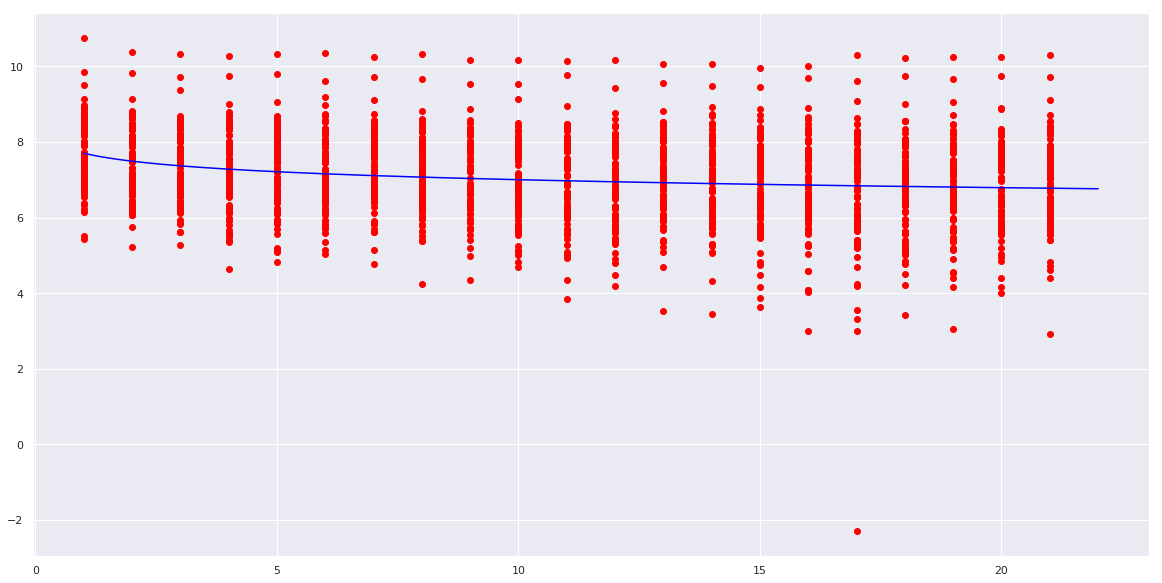

In [112]:
x3=np.linspace(1,22,1000) #用于画图精度的调节
x0=[]
for i in range(21):
    x0.append(i+1)
x0=x0*len(dts)
x2=np.array(x0) #向量化x变量
y0=[]
for i in range(len(dts)):
    y0+=dts.iloc[i]['GMV列表']
y0=np.log(y0) #y
y2=np.array(y0)#向量化
p0=[1,3400]#取值起始点
    
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法
f,ax = plt.subplots(figsize = (20,10))

pl.scatter(x0,y0,label='Real',color='red')
pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [113]:
qs

(array([-0.30432073,  7.70311344]), 1)

时间序列模型：

In [224]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation='90')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['value'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [196]:
date='2019-05-01'
date_index_list=[]
for i in range(len(GMV_list_ave)):
    date_index_list.append(str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10],)

val = {'date_index':date_index_list,'value':GMV_list_ave}
lw_list=pd.DataFrame(val)

In [197]:
lw_list=lw_list.set_index('date_index')

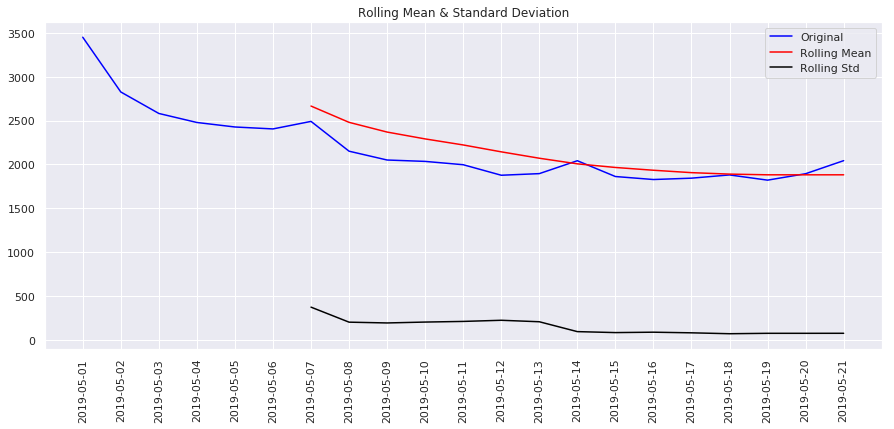

Results of Dickey-Fuller Test:
Test Statistic                  0.000000
p-value                         0.958532
#Lags Used                      9.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [225]:
test_stationarity(lw_list)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

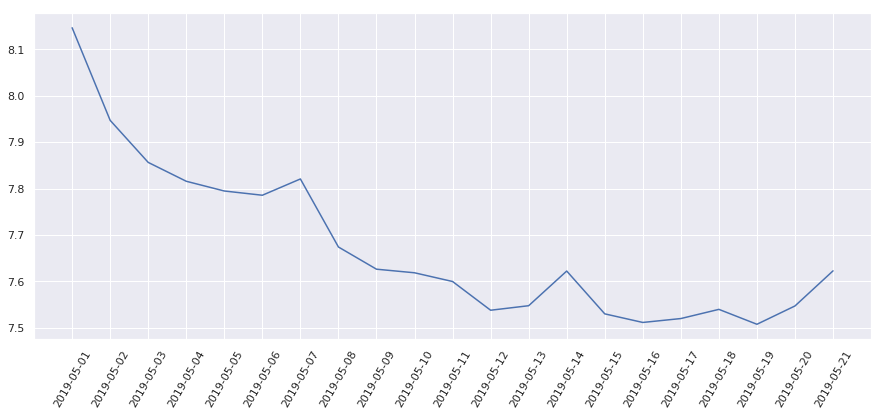

In [194]:
value_log = np.log(lw_list['value'])
plt.plot(value_log)
plt.xticks(rotation='60')

纵向时间序列

In [205]:
dts.iloc[48]

日期                                                 2019-04-18
vip_list    [36801, 118543, 151643, 176012, 180410, 182020...
GMV列表       [47166.219824805856, 32058.749902129173, 30519...
Name: 48, dtype: object

In [252]:
GMV_list_day=[]
date_index=[]
date='2019-03-01'
for i in range(len(dts)):
    GMV_list_day.append(np.log(dts.iloc[i]['GMV列表'][0]))
    date_index.append(str(datetime.datetime.strptime(date,'%Y-%m-%d')+datetime.timedelta(days=i))[:10],)

val1 = {'date_index':date_index,'value':GMV_list_day}
GMV_list=pd.DataFrame(val1)    

#GMV_list['date_index'] = pd.datetime.strptime(GMV_list['date_index'], '%Y-%m-%d')

In [255]:
GMV_list['date_index']=pd.to_datetime(GMV_list['date_index'])

([<matplotlib.lines.Line2D at 0x7f881efc5128>],
 [<matplotlib.lines.Line2D at 0x7f881efc52b0>])

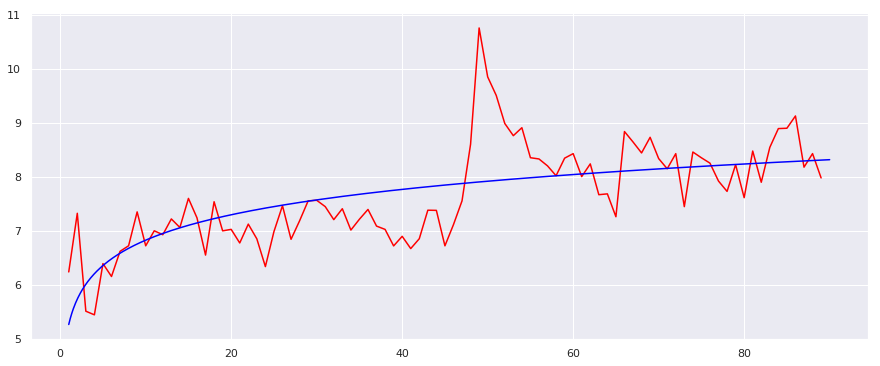

In [259]:
x3=np.linspace(1,len(dts)+1,1000) #用于画图精度的调节

x0 = []
for i in range(len(dts)):
    x0.append(i+1)
#x0=[range(21)] #x变量, 
x2=np.array(x0) #向量化x变量
y0=GMV_list_day
y2=np.array(y0)#向量化
p0=[1,3400]#取值起始点
    
qs=leastsq(residuals,p0,args=(y2,x2)) #最小二乘法

pl.plot(x0,y0,label='Real',color='red'),pl.plot(x3,func(x3,qs[0]),label='sim',color='blue') #预测图像

In [256]:
GMV_list=GMV_list.set_index('date_index')

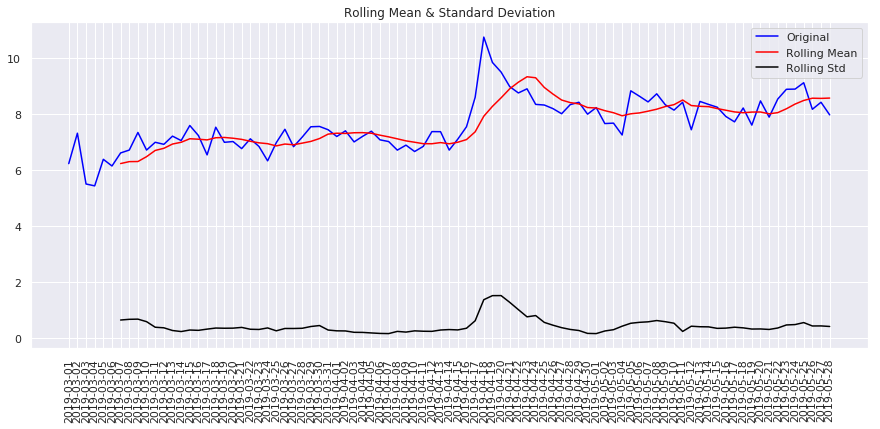

Results of Dickey-Fuller Test:
Test Statistic                 -3.275199
p-value                         0.016024
#Lags Used                      0.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [240]:
test_stationarity(GMV_list)

In [241]:
#消除趋势
GMV_list_diff = GMV_list - GMV_list.shift()

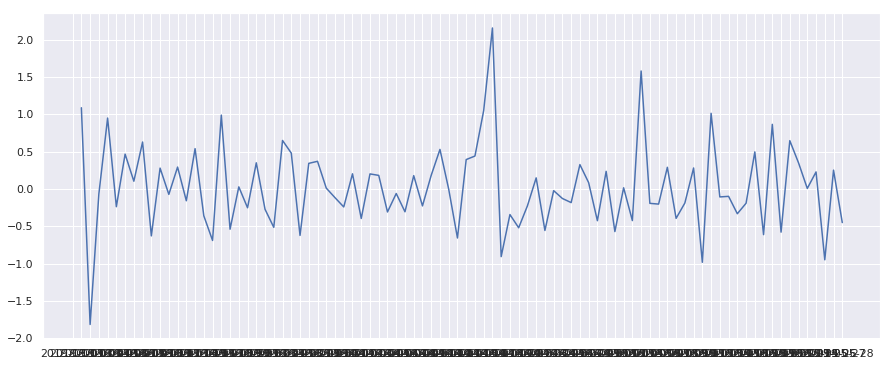

In [242]:
plt.plot(GMV_list_diff)
#plt.xticks(rotation='90')


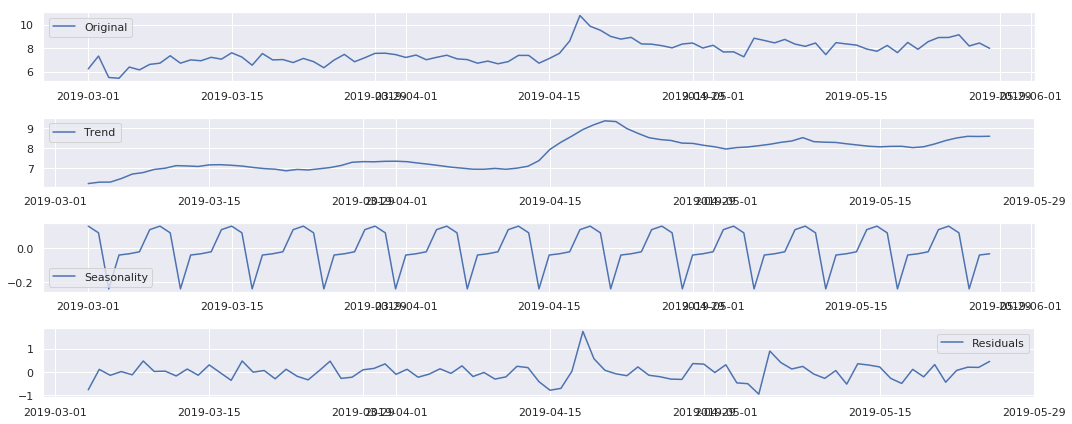

In [257]:
#分解
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(GMV_list)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(GMV_list, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()